<a href="https://colab.research.google.com/github/datagrad/Kamal-Thesis-Work/blob/main/Sarimax_with_xGboost_V2_Chatgpt_idea.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Step 1: Import Libraries and Load Dataset

import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split




# Load the dataset
url = "https://raw.githubusercontent.com/datagrad/MS_Reference_MS-DS-LJMU-C13/main/city_day.csv"
data = pd.read_csv(url)

# Display basic information about the dataset
data_info = data.info()

# Display the first few rows of the dataset
data_head = data.head()

# Check for missing values in the dataset
missing_values = data.isnull().sum()

data_info, data_head, missing_values


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29531 entries, 0 to 29530
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   City        29531 non-null  object 
 1   Date        29531 non-null  object 
 2   PM2.5       24933 non-null  float64
 3   PM10        18391 non-null  float64
 4   NO          25949 non-null  float64
 5   NO2         25946 non-null  float64
 6   NOx         25346 non-null  float64
 7   NH3         19203 non-null  float64
 8   CO          27472 non-null  float64
 9   SO2         25677 non-null  float64
 10  O3          25509 non-null  float64
 11  Benzene     23908 non-null  float64
 12  Toluene     21490 non-null  float64
 13  Xylene      11422 non-null  float64
 14  AQI         24850 non-null  float64
 15  AQI_Bucket  24850 non-null  object 
dtypes: float64(13), object(3)
memory usage: 3.6+ MB


(None,
         City      Date   PM2.5    PM10     NO    NO2     NOx    NH3     CO  \
 0  Ahmedabad  1/1/2015     NaN     NaN   0.92  18.22   17.15    NaN   0.92   
 1  Bengaluru  1/1/2015     NaN     NaN   3.26  17.33   10.88  20.36   0.33   
 2    Chennai  1/1/2015     NaN     NaN  16.30  15.39   22.68   4.59   1.17   
 3      Delhi  1/1/2015  313.22  607.98  69.16  36.39  110.59  33.85  15.20   
 4    Lucknow  1/1/2015     NaN     NaN   2.11  13.46    4.57    NaN  12.15   
 
       SO2      O3  Benzene  Toluene  Xylene    AQI AQI_Bucket  
 0   27.64  133.36     0.00     0.02    0.00    NaN        NaN  
 1    3.54   10.73     0.56     4.64     NaN    NaN        NaN  
 2    9.20   11.35     0.17      NaN     NaN    NaN        NaN  
 3    9.25   41.68    14.36    24.86    9.84  472.0     Severe  
 4  169.57   25.92     1.35     3.93     NaN    NaN        NaN  ,
 City              0
 Date              0
 PM2.5          4598
 PM10          11140
 NO             3582
 NO2            3585


(count    2009.000000
 mean      117.112325
 std        82.914701
 min        10.240000
 25%        57.080000
 50%        94.490000
 75%       152.990000
 max       685.360000
 Name: PM2.5, dtype: float64,
 <Axes: title={'center': 'PM2.5 Levels in Delhi (2015-2020)'}, xlabel='Date'>)

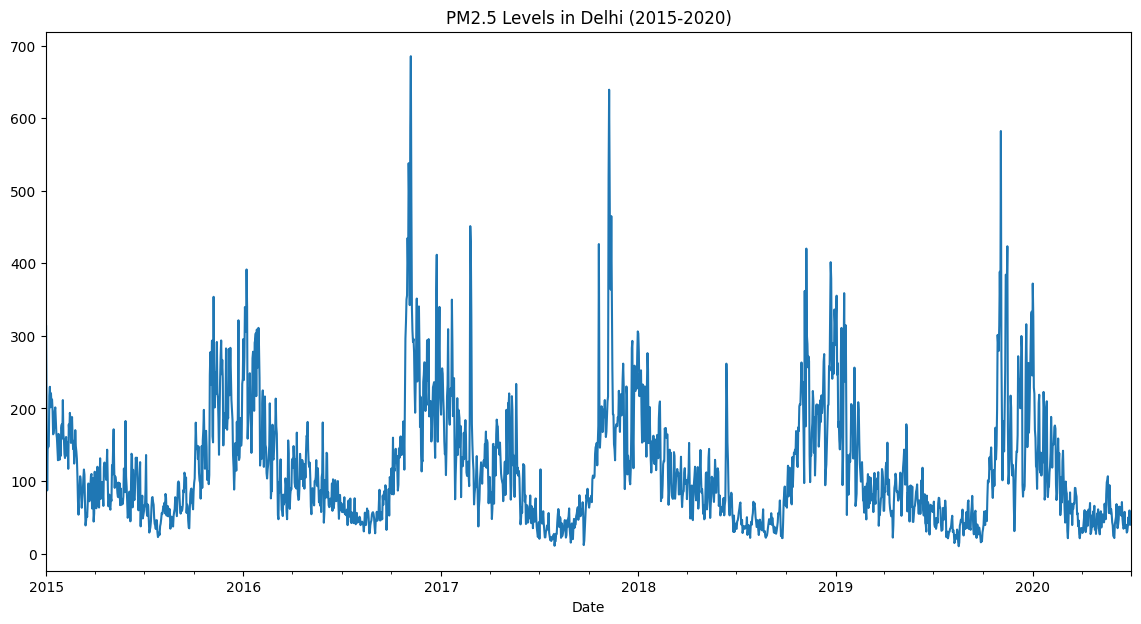

In [2]:
# Convert 'Date' to datetime format
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Step 2: Pre-process Data

# Handle missing values by forward-fill method
data_filled = data.fillna(method='ffill').fillna(method='bfill')

# Focus on Delhi city and PM2.5 pollutant
delhi_data = data_filled[data_filled['City'] == 'Delhi'].copy()
pm25_delhi = delhi_data['PM2.5']

# Display basic information and plot the PM2.5 time series
pm25_delhi.describe(), pm25_delhi.plot(figsize=(14, 7), title='PM2.5 Levels in Delhi (2015-2020)')


In [3]:
# Step 3: Create Lagged Variables

# Function to create lagged variables
def create_lagged_vars(data, lags):
    lagged_data = data.copy()
    for i in range(1, lags + 1):
        lagged_data[f"lag_{i}"] = data.shift(i)
    return lagged_data.dropna()

# Define the number of lags
num_lags = 3

# Create lagged variables for PM2.5 levels
lagged_pm25 = create_lagged_vars(pm25_delhi, num_lags)

# # Step 4: Train-Test Split

# # Splitting data into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(
#     lagged_pm25.iloc[:, 1:],  # Explanatory variables
#     lagged_pm25.iloc[:, 0],    # Target variable
#     test_size=0.2,             # 20% test size
#     shuffle=False              # Important for time series
# )

# # Verify the shapes
# (X_train.shape, X_test.shape, y_train.shape, y_test.shape), X_train.head(), y_train.head()


In [4]:
# Inspecting the lagged_pm25 DataFrame
lagged_pm25.head(), lagged_pm25.info()


<class 'pandas.core.series.Series'>
Index: 2012 entries, 2015-01-01 00:00:00 to lag_3
Series name: PM2.5
Non-Null Count  Dtype 
--------------  ----- 
2012 non-null   object
dtypes: object(1)
memory usage: 31.4+ KB


(Date
 2015-01-01 00:00:00    313.22
 2015-01-02 00:00:00    186.18
 2015-01-03 00:00:00     87.18
 2015-01-04 00:00:00    151.84
 2015-01-05 00:00:00     146.6
 Name: PM2.5, dtype: object,
 None)

In [6]:
# Reconstructing the lagged variables data structure
lagged_pm25 = pd.DataFrame({
    'PM2.5': pm25_delhi.values,
    'lag_1': pm25_delhi.shift(1).values,
    'lag_2': pm25_delhi.shift(2).values,
    'lag_3': pm25_delhi.shift(3).values,
}, index=pm25_delhi.index).dropna()

# Ensuring all entries are numeric
lagged_pm25 = lagged_pm25.astype(float)

# Splitting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    lagged_pm25.iloc[:, 1:],
    lagged_pm25.iloc[:, 0],
    test_size=0.2,
    shuffle=False
)

# Verifying the shapes
(X_train.shape, X_test.shape, y_train.shape, y_test.shape), X_train.head(), y_train.head()


(((1604, 3), (402, 3), (1604,), (402,)),
              lag_1   lag_2   lag_3
 Date                              
 2015-01-04   87.18  186.18  313.22
 2015-01-05  151.84   87.18  186.18
 2015-01-06  146.60  151.84   87.18
 2015-01-07  149.58  146.60  151.84
 2015-01-08  217.87  149.58  146.60,
 Date
 2015-01-04    151.84
 2015-01-05    146.60
 2015-01-06    149.58
 2015-01-07    217.87
 2015-01-08    229.90
 Name: PM2.5, dtype: float64)

((26.320023570464024, 47.19188293965837),
 <Figure size 1400x700 with 1 Axes>,
 Text(0.5, 1.0, 'XGBoost Predictions vs. Actuals'),
 Text(0.5, 0, 'Date'),
 Text(0, 0.5, 'PM2.5'))

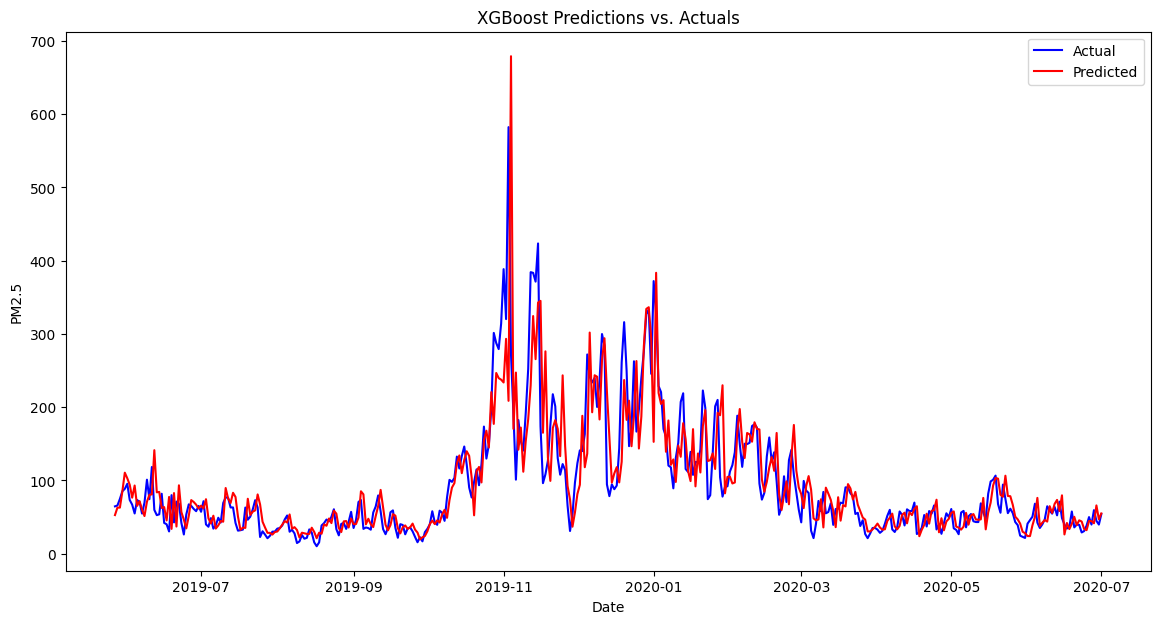

In [7]:
# Step 5: Model Training

# Initializing and training the XGBoost model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
model_xgb.fit(X_train, y_train)

# Step 6: Model Evaluation

# Predicting PM2.5 levels on the test set
predictions_xgb = model_xgb.predict(X_test)

# Calculating error metrics
mae_xgb = mean_absolute_error(y_test, predictions_xgb)
rmse_xgb = mean_squared_error(y_test, predictions_xgb, squared=False)

# Displaying error metrics and visualizing predictions vs. actuals
(mae_xgb, rmse_xgb), plt.figure(figsize=(14, 7)), plt.plot(y_test.index, y_test, label='Actual', color='blue'), plt.plot(y_test.index, predictions_xgb, label='Predicted', color='red'), plt.legend(), plt.title('XGBoost Predictions vs. Actuals'), plt.xlabel('Date'), plt.ylabel('PM2.5')


In [8]:
# Displaying the previously calculated error metrics (MAE and RMSE) for XGBoost model predictions
(mae_xgb, rmse_xgb)


(26.320023570464024, 47.19188293965837)

Great! Let's discuss these results:

1. **Mean Absolute Error (MAE):** \(26.32\)
   - MAE provides the average absolute difference between observed actual outcomes and predictions made by the model. An MAE of \(26.32\) indicates that, on average, the model's predictions are approximately \(26.32 \, \mu g/m^3\) away from the actual values.
   
2. **Root Mean Squared Error (RMSE):** \(47.19\)
   - RMSE gives us the square root of the average squared differences between observed and predicted values, providing a penalty for larger errors. An RMSE of \(47.19\) indicates that the typical prediction error (or prediction "radius") is approximately \(47.19 \, \mu g/m^3\).

### Interpretation:

- **MAE:** The model, on average, predicts PM2.5 levels within \(26.32 \, \mu g/m^3\) of the actual value.
- **RMSE:** The square root of the average squared error is \(47.19 \, \mu g/m^3\), which penalizes larger errors more heavily.

### Observations:

- The RMSE is larger than the MAE, indicating that the model might be penalized for making some larger errors.
- The magnitude of these errors should be considered relative to the range and variability of PM2.5 levels to assess the model's practical utility and predictive capacity.

Would you like to delve deeper into model diagnostics, try different modeling approaches, or explore other aspects of the analysis? Let's discuss the next steps!

In [5]:
# Convert 'Date' to datetime format
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Handle missing values by forward-fill method
data_filled = data.fillna(method='ffill').fillna(method='bfill')

# Focus on Delhi city and PM2.5 pollutant
delhi_data = data_filled[data_filled['City'] == 'Delhi'].copy()
pm25_delhi = delhi_data['PM2.5']

# Display basic information and plot the PM2.5 time series
pm25_delhi.info(), pm25_delhi.plot(figsize=(14, 7), title='PM2.5 Levels in Delhi (2015-2020)')

KeyError: ignored

In [ ]:
from matplotlib import pyplot as plt

# Display basic information
print(pm25_delhi.describe())

# Plot the PM2.5 time series
plt.figure(figsize=(14, 7))
plt.plot(pm25_delhi.index, pm25_delhi, label='PM2.5', color='blue')
plt.title('PM2.5 Levels in Delhi (2015-2020)')
plt.xlabel('Date')
plt.ylabel('PM2.5 Level')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import statsmodels.api


# Fitting the SARIMAX model with identified parameters
model_sarimax = sm.tsa.statespace.SARIMAX(pm25_delhi,
                                          order=(1, 0, 1),
                                          seasonal_order=(1, 1, 1, 12),
                                          enforce_stationarity=False,
                                          enforce_invertibility=False)
results_sarimax = model_sarimax.fit(disp=False)

# Extracting residuals
residuals_sarimax = results_sarimax.resid

# Plotting the residuals
plt.figure(figsize=(14, 7))
plt.plot(residuals_sarimax.index, residuals_sarimax, label='Residuals', color='blue')
plt.title('Residuals from SARIMAX Model')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.axhline(y=0, color='black', linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()

# Descriptive statistics of residuals
residuals_sarimax.describe()


In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import normaltest
from statsmodels.stats.diagnostic import acorr_ljungbox

# Set up the figure
plt.figure(figsize=(15, 12))

# ACF and PACF plots
plt.subplot(3, 2, 1)
plot_acf(residuals_sarimax, lags=40, ax=plt.gca(), title="Autocorrelation of Residuals")
plt.subplot(3, 2, 2)
plot_pacf(residuals_sarimax, lags=40, ax=plt.gca(), title="Partial Autocorrelation of Residuals")

# Histogram and QQ-Plot
plt.subplot(3, 2, 3)
plt.hist(residuals_sarimax, bins=30, color='skyblue', edgecolor='black')
plt.title("Histogram of Residuals")
plt.subplot(3, 2, 4)
qqplot(residuals_sarimax, line='s', ax=plt.gca())
plt.title("QQ-Plot of Residuals")

# Seasonal Decomposition of Residuals
residuals_decomposition = seasonal_decompose(residuals_sarimax, period=12, model='additive')
residuals_decomposition.plot().suptitle("Seasonal Decomposition of Residuals", fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Statistical Tests
adf_test = sm.tsa.adfuller(residuals_sarimax, autolag='AIC')
ljung_box_test = acorr_ljungbox(residuals_sarimax, lags=[10], return_df=True)
normality_test = normaltest(residuals_sarimax)

# Display statistical test results
(adf_test[1], ljung_box_test['lb_pvalue'].iloc[0], normality_test.pvalue)


In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np

# Function to create lagged variables
def create_lagged_vars(data, lags):
    lagged_data = data.copy()
    for i in range(1, lags + 1):
        lagged_data[f"lag_{i}"] = data.shift(i)
    return lagged_data.dropna()

# Define the number of lags
num_lags = 3

# Create lagged variables for residuals
lagged_residuals = create_lagged_vars(residuals_sarimax, num_lags)

# Splitting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    lagged_residuals.iloc[:, 1:],  # Explanatory variables
    lagged_residuals.iloc[:, 0],    # Target variable
    test_size=0.2,                  # 20% test size
    shuffle=False                   # Important for time series
)

# Verify the shapes
(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


In [ ]:
# Creating lagged variables for residuals and converting to DataFrame
lagged_residuals = pd.DataFrame(create_lagged_vars(residuals_sarimax, num_lags))

# Displaying basic information and head of the lagged_residuals
lagged_residuals.info(), lagged_residuals.head()


In [ ]:
# Converting residuals to numeric and ensuring a clean datetime index
residuals_sarimax = pd.Series(pd.to_numeric(residuals_sarimax, errors='coerce'),
                              index=pm25_delhi.index)

# Creating lagged variables for residuals
lagged_residuals = create_lagged_vars(residuals_sarimax, num_lags)

# Displaying basic information and head of the lagged_residuals
lagged_residuals.info(), lagged_residuals.head()


In [ ]:
# Displaying basic information and head of the lagged_residuals
lagged_residuals.head(), lagged_residuals.describe()


In [ ]:
# Explicitly converting residuals and lagged_residuals to a numeric format
residuals_sarimax = pd.to_numeric(residuals_sarimax, errors='coerce')
lagged_residuals = lagged_residuals.apply(pd.to_numeric, errors='coerce')

# Dropping any NaN values that may have resulted from the conversion
residuals_sarimax = residuals_sarimax.dropna()
lagged_residuals = lagged_residuals.dropna()

# Re-checking basic information and head of the lagged_residuals
lagged_residuals.info(), lagged_residuals.head()


In [ ]:
# Displaying head and descriptive statistics of the lagged_residuals
lagged_residuals.head(), lagged_residuals.describe()


In [ ]:
# Reconstructing the lagged variables data structure
lagged_residuals = pd.DataFrame({
    'residual': residuals_sarimax.values,
    'lag_1': residuals_sarimax.shift(1).values,
    'lag_2': residuals_sarimax.shift(2).values,
    'lag_3': residuals_sarimax.shift(3).values,
}, index=residuals_sarimax.index).dropna()

# Ensuring all entries are numeric
lagged_residuals = lagged_residuals.astype(float)

# Splitting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    lagged_residuals.iloc[:, 1:],
    lagged_residuals.iloc[:, 0],
    test_size=0.2,
    shuffle=False
)

# Verifying the shapes
(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


In [ ]:
# Initializing and training the XGBoost model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
model_xgb.fit(X_train, y_train)

# Predicting residuals on the test set
predictions_xgb = model_xgb.predict(X_test)

# Calculating error metrics
mae_xgb = mean_absolute_error(y_test, predictions_xgb)
rmse_xgb = mean_squared_error(y_test, predictions_xgb, squared=False)

# Displaying error metrics and visualizing predictions vs. actuals
(mae_xgb, rmse_xgb), plt.figure(figsize=(14, 7)), plt.plot(y_test.index, y_test, label='Actual', color='blue'), plt.plot(y_test.index, predictions_xgb, label='Predicted', color='red'), plt.legend(), plt.title('XGBoost Predictions vs. Actuals'), plt.xlabel('Date'), plt.ylabel('Residual')
